In [2]:
# For manipulating and analyzing data
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns

# For Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset

# For making the model
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam

# For evaluating the model
from sklearn.metrics import confusion_matrix

# For visualization
from PIL import Image

In [3]:
dataset = pd.read_csv('pokemon.csv')
print(dataset.shape)
ends = pd.concat([dataset.head(), dataset.tail()])
ends

(801, 41)


,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,against_ground,against_ice,against_normal,against_poison,against_psychic,against_rock,against_steel,against_water,attack,base_egg_steps,base_happiness,base_total,capture_rate,classfication,defense,experience_growth,height_m,hp,japanese_name,name,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,49,5120,70,318,45,Seed Pokémon,49,1059860,0.7,45,Fushigidaneフシギダネ,Bulbasaur,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,62,5120,70,405,45,Seed Pokémon,63,1059860,1.0,60,Fushigisouフシギソウ,Ivysaur,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,100,5120,70,625,45,Seed Pokémon,123,1059860,2.0,80,Fushigibanaフシギバナ,Venusaur,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0,52,5120,70,309,45,Lizard Pokémon,43,1059860,0.6,39,Hitokageヒトカゲ,Charmander,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0,64,5120,70,405,45,Flame Pokémon,58,1059860,1.1,58,Lizardoリザード,Charmeleon,88.1,5,80,65,80,fire,NaN,19.0,1,0
796,['Beast Boost'],0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,0.25,0.0,1.0,0.5,0.0,0.5,1.0,0.5,1.0,101,30720,0,570,25,Launch Pokémon,103,1250000,9.2,97,Tekkaguyaテッカグヤ,Celesteela,NaN,797,107,101,61,steel,flying,999.9,7,1
797,['Beast Boost'],1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,0.25,1.0,1.0,0.5,0.0,0.5,0.5,0.5,0.5,181,30720,0,570,255,Drawn Sword Pokémon,131,1250000,0.3,59,Kamiturugiカミツルギ,Kartana,NaN,798,59,31,109,grass,steel,0.1,7,1
798,['Beast Boost'],2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,0.50,1.0,2.0,1.0,1.0,0.0,1.0,1.0,0.5,101,30720,0,570,15,Junkivore Pokémon,53,1250000,5.5,223,Akuzikingアクジキング,Guzzlord,NaN,799,97,53,43,dark,dragon,888.0,7,1
799,['Prism Armor'],2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,1.00,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,107,30720,0,600,3,Prism Pokémon,101,1250000,2.4,97,Necrozmaネクロズマ,Necrozma,NaN,800,127,89,79,psychic,NaN,230.0,7,1
800,['Soul-Heart'],0.25,0.5,0.0,1.0,0.5,1.0,2.0,0.5,1.0,0.50,2.0,0.5,0.5,0.0,0.5,0.5,1.0,1.0,95,30720,0,600,3,Artificial Pokémon,115,1250000,1.0,80,Magearnaマギアナ,Magearna,NaN,801,130,115,65,steel,fairy,80.5,7,1


<Axes: xlabel='is_legendary', ylabel='count'>

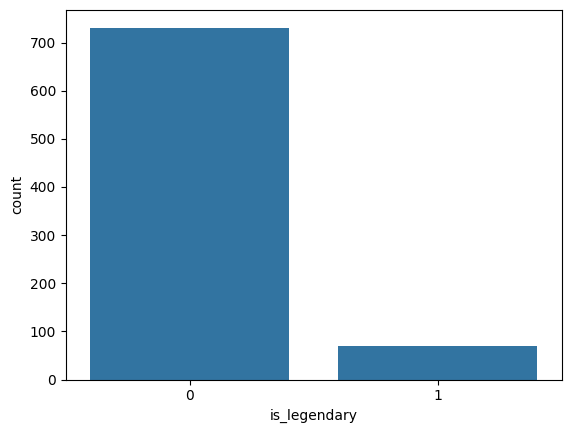

In [5]:
# How does the class label distribution look?
# We want a fairly even distribution of 0 to 1 labels (non-legendary to legendary in this case)
sns.countplot(x='is_legendary', data=dataset)

In [6]:
# There are many less legendaries than non-legendaries, so it's an imbalanced dataset.

In [7]:
# Build the dataframe with only columns where dtype is not object
dataset_cleaned = dataset.select_dtypes(exclude=['object'])
# Drop specific columns that intuitively are unhelpful
dataset_cleaned = dataset_cleaned.drop(columns=dataset_cleaned.filter(regex='^against').columns)
dataset_cleaned = dataset_cleaned.drop(['pokedex_number', 'generation'], axis=1)
# Drop percentage_male because it's null for most legenedaries
dataset_cleaned = dataset_cleaned.drop(['percentage_male'], axis=1)
# Drop rows with nan values
dataset_cleaned = dataset_cleaned.dropna()

In [8]:
# Check how many legendaries were dropped
print(dataset.loc[dataset['is_legendary'] != 0].shape)
print(dataset_cleaned.loc[dataset_cleaned['is_legendary'] != 0].shape)

(70, 41)
(69, 13)


In [9]:
# Print current state of the dataset
print(dataset_cleaned.shape)
dataset_cleaned.head()

(781, 13)


,attack,base_egg_steps,base_happiness,base_total,defense,experience_growth,height_m,hp,sp_attack,sp_defense,speed,weight_kg,is_legendary
0,49,5120,70,318,49,1059860,0.7,45,65,65,45,6.9,0
1,62,5120,70,405,63,1059860,1.0,60,80,80,60,13.0,0
2,100,5120,70,625,123,1059860,2.0,80,122,120,80,100.0,0
3,52,5120,70,309,43,1059860,0.6,39,60,50,65,8.5,0
4,64,5120,70,405,58,1059860,1.1,58,80,65,80,19.0,0


<Axes: xlabel='is_legendary', ylabel='count'>

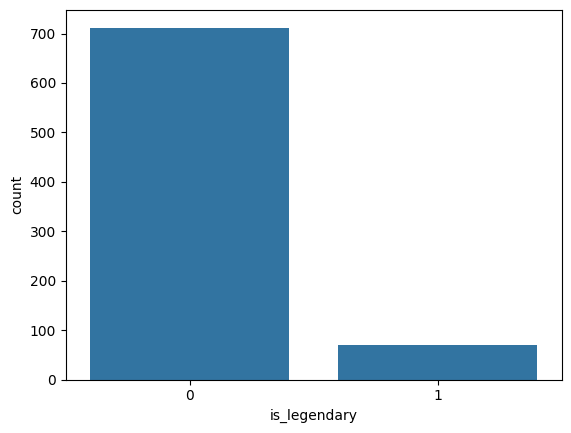

In [10]:
sns.countplot(x='is_legendary', data=dataset_cleaned)

In [11]:
# Split the data into inputs and labels
X = dataset_cleaned.iloc[:, :-1] # all rows, all but last column
Y = dataset_cleaned.iloc[:, -1] # all rows, only last column

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2^31-1, stratify=Y) # stratify keeps the label distribution roughly equal between training and test sets
print(Y_train.describe())
print()
print(Y_test.describe())

count    624.000000
mean       0.088141
std        0.283727
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: is_legendary, dtype: float64

count    157.000000
mean       0.089172
std        0.285904
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: is_legendary, dtype: float64


In [13]:
 # Dataframes to numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()

X_train[0], Y_train[0]

(array([4.00e+01, 5.12e+03, 7.00e+01, 2.80e+02, 5.50e+01, 1.00e+06,
        6.00e-01, 3.00e+01, 4.00e+01, 5.50e+01, 6.00e+01, 1.12e+01]),
 0)

In [14]:
# Standardize the data to improve performance of the model (centers the data at 0 with std of 1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [15]:
# More imports
import torch

In [16]:
# Build Dataset class
## Train Data (inputs and labels)
class TrainData(Dataset): # inherit from Dataset class
    def __init__(self, X_data, Y_data):
        self.x_data = X_data
        self.y_data = Y_data

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return len(self.x_data)

## Test Data (just inputs)
class TestData(Dataset): # inherit from Dataset class
    def __init__(self, X_data):
        self.x_data = X_data

    def __getitem__(self, index):
        return self.x_data[index]

    def __len__(self):
        return len(self.x_data)

train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(Y_train))
test_data = TestData(torch.FloatTensor(X_test))

In [17]:
train_data[0], test_data[0]

((tensor([-1.1673, -0.3287,  0.2522, -1.2381, -0.5674, -0.3439, -0.5122, -1.4132,
          -0.9751, -0.5594, -0.2312, -0.4544]),
  tensor(0.)),
 tensor([ 2.5615, -0.4792,  0.1996,  2.0119,  0.9519,  1.2002,  1.1260,  3.7505,
          0.6972, -0.2922,  1.2418,  0.7089]))

The Model

In [18]:
### Hyperparameters
# for the model
HIDDEN_SIZE = 64
# for training
EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [19]:
# Build Dataloader
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [20]:
 # Define model
class PokemonModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(PokemonModel, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.batchnorm2 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(hidden_size, 1)

        self.layers = [
            self.l1,
            self.relu1,
            self.batchnorm1,
            self.l2,
            self.relu2,
            self.batchnorm2,
            self.dropout,
            self.out
        ]

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [21]:
# Initialize model
model = PokemonModel(input_size=X_train.shape[1], hidden_size=HIDDEN_SIZE)
model.to(device)
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
model


PokemonModel(
  (l1): Linear(in_features=12, out_features=64, bias=True)
  (relu1): ReLU()
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [22]:
# Define the accuracy metric
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

In [23]:
model.train() # Put model into 'train mode', which includes dropout and batchnorm layers. Regularly, they are excluded
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()

        Y_pred = model(X_batch)

        loss = criterion(Y_pred, Y_batch.unsqueeze(1))
        acc = binary_acc(Y_pred, Y_batch.unsqueeze(1))

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')


Epoch 001: | Loss: 0.63478 | Acc: 66.750
Epoch 002: | Loss: 0.50302 | Acc: 86.050
Epoch 003: | Loss: 0.43730 | Acc: 89.650
Epoch 004: | Loss: 0.36294 | Acc: 92.600
Epoch 005: | Loss: 0.30741 | Acc: 94.000
Epoch 006: | Loss: 0.25300 | Acc: 96.200
Epoch 007: | Loss: 0.20539 | Acc: 96.700
Epoch 008: | Loss: 0.17031 | Acc: 98.200
Epoch 009: | Loss: 0.13639 | Acc: 98.950
Epoch 010: | Loss: 0.11142 | Acc: 99.400
Epoch 011: | Loss: 0.08838 | Acc: 99.400
Epoch 012: | Loss: 0.07022 | Acc: 99.550
Epoch 013: | Loss: 0.05590 | Acc: 99.550
Epoch 014: | Loss: 0.05131 | Acc: 99.700
Epoch 015: | Loss: 0.04096 | Acc: 99.850
Epoch 016: | Loss: 0.03476 | Acc: 100.000
Epoch 017: | Loss: 0.02942 | Acc: 100.000
Epoch 018: | Loss: 0.02620 | Acc: 100.000
Epoch 019: | Loss: 0.02209 | Acc: 100.000
Epoch 020: | Loss: 0.01941 | Acc: 100.000


In [24]:
Y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_test_pred = model(X_batch)
        Y_test_pred = torch.sigmoid(Y_test_pred)
        Y_pred_tag = torch.round(Y_test_pred)
        Y_pred_list.append(Y_pred_tag.cpu().numpy())
    
Y_pred_list = [a.squeeze().tolist() for a in Y_pred_list]

In [25]:
confusion_matrix(Y_test, Y_pred_list)

array([[142,   1],
       [  1,  13]], dtype=int64)

Lets look at some specific cases

In [1]:
# Import the pictures
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arenagrenade/the-complete-pokemon-images-data-set")

print("Path to dataset files:", path)

c:\Users\gross\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\gross\.cache\kagglehub\datasets\arenagrenade\the-complete-pokemon-images-data-set\versions\1


Pokemon: mesprit
Legendary: 1.000


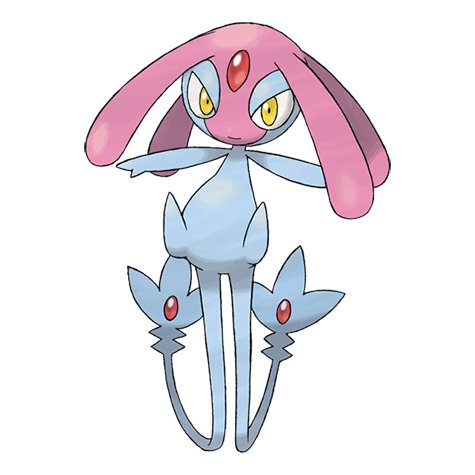

In [27]:
# Get a legendary pokemon from the dataframe
# pokemon = dataset.sample()                                # sample any pokemon
pokemon = dataset[dataset['is_legendary'] == 1].sample()    # sample a legendary pokemon
# Get the pokemon name
pokemon_name = pokemon['name'].values[0].lower()

# Clean example as before
pokemon = pokemon[dataset_cleaned.columns].values[0][:-1]
pokemon = scaler.transform(pokemon.reshape(1, -1))
pokemon = torch.FloatTensor(pokemon)
# Predict
model.eval()
with torch.no_grad():
    Y_pred = model(pokemon.to(device))
    Y_pred = torch.sigmoid(Y_pred)

img = Image.open(f'pokemon_images/{pokemon_name}.png')
print(f'Pokemon: {pokemon_name}')
print(f'Legendary: {Y_pred.item():.3f}')
img